## Reporte: Comparación de variables en poblaciones pediátricas y no pediátricas

Los archivos en esta carpeta permiten generar las ilustraciones y tablas asociados al reporte *Comparación de variables en poblaciones pediátricas y no pediátricas* realizado en el marco del proyecto FONDEF ID23I10423 
*Sistema informático en base a inteligencia artificial para predecir peak de hospitalizaciones pediátricas por causas respiratorias*.

In [1]:
## Importar librerias necesarias
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

In [2]:
year = 2019
grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
grupos_etarios_legend = ["Menores 1","De 1 a 4","De 5 a 14","De 15 a 64","De 65 y más"]

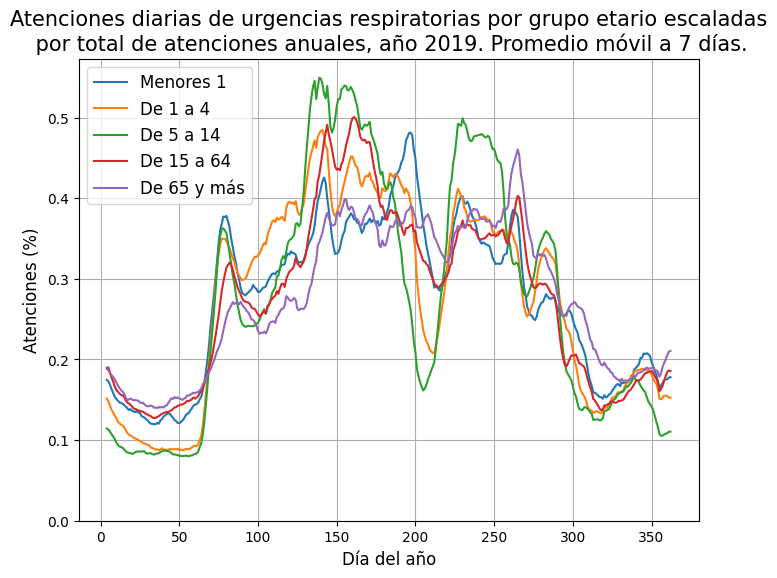

In [6]:
# ILUSTRACIÓN 2 CURVAS DE DEMANDA PARA DIFERENTES GRUPOS ETARIOS, AÑO FIJO
#Comparacion de datos para diferentes grupos etarios para un año fijo
#se usa una media movil a  7 dias de las curvas de atenciones diarias escaladas 
# sobre el total de atenciones anuales
df = duckdb.sql("""
select 
      year(strptime(fecha, '%d/%m/%Y')) as year
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , sum(Menores_1) as Menores_1
    , sum(De_1_a_4) as De_1_a_4
    , sum(De_5_a_14) as De_5_a_14
    , sum(De_15_a_64) as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11) 
and year(strptime(fecha, '%d/%m/%Y')) in (""" + str(year) + """)
group by year, nrodia
order by year, nrodia
""").df()

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 

ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for column in grupos_etarios:
    plt.plot(df['nrodia'],100*df[column].rolling(7,center=True).mean()/float(sum(df[column]))) # c = color)

plt.legend(grupos_etarios_legend, loc ="upper left",fontsize  = 12)
ax.set_ylim(ymin=0)
ax.grid()
ax.set_title('Atenciones diarias de urgencias respiratorias por grupo etario escaladas\n por total de atenciones anuales, año 2019. Promedio móvil a 7 días.', fontsize = 15)
ax.set_xlabel('Día del año', fontsize = 12)
ax.set_ylabel('Atenciones (%)', fontsize = 12)

plt.savefig('fig2_urgencias_grupo_etario_2019.png', bbox_inches='tight')